# **Pobieranie danych**

In [1]:
# from binance import Client
# import pandas as pd
# import os

# def get_price_data(symbol, timeframe, start, end=None):
#     klines = Client().get_historical_klines(symbol, timeframe, start, end)
#     data = pd.DataFrame(klines, columns=['Timestamp', 'Open', 'High', 'Low', 'Close', 'Volume', 'Close_Time', 'Quote_Asset_Volume', 'Number_Of_Trades', 'Taker_Buy_Base', 'Taker_Buy_Quote', 'Ignore'])
#     data = data[['Timestamp', 'Open', 'High', 'Low', 'Close', 'Volume']]
#     data['Timestamp'] = pd.to_datetime(data['Timestamp'], unit='ms')
#     data['Open'] = pd.to_numeric(data['Open'])
#     data['High'] = pd.to_numeric(data['High'])
#     data['Low'] = pd.to_numeric(data['Low'])
#     data['Close'] = pd.to_numeric(data['Close'])
#     data['Volume'] = pd.to_numeric(data['Volume'])
#     data.set_index('Timestamp', inplace=True)
#     return data

# symbol = "BTCUSDT"
# timeframe = Client.KLINE_INTERVAL_1DAY 
# start_date = "2019.09.08" # Earliest available data from Binance
# end_date = "2024.12.31"

# folder = f"./data/{timeframe}"
# os.makedirs(folder, exist_ok=True)
# file_path = f"{folder}/{start_date}-{end_date}-{symbol}.csv"

# if os.path.exists(file_path):
#     print(f"Plik {file_path} już istnieje. Pomijam pobieranie.")
# else:
#     df = get_price_data(symbol, timeframe, start_date, end_date)
#     df.to_csv(file_path)
#     print(f"Pobrano i zapisano dane dla {symbol}: {file_path}")

# **Import**

In [2]:
import os

import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, root_mean_squared_error
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from sklearn.preprocessing import MinMaxScaler
from sklearn.inspection import permutation_importance

import ta

from tensorflow.keras.utils import to_categorical # type: ignore
from keras.models import Sequential # type: ignore
from keras.layers import LSTM, GRU, Dense, Input # type: ignore

from enum import Enum
from tqdm.notebook import tqdm

In [3]:
pd.set_option('display.max_columns', None)

# **Przygotowanie danych**

## Ładowanie danych z pliku

In [32]:
file_path = "./2019.09.08-2024.12.31-BTCUSDT.csv"

if os.path.exists(file_path):
    df = pd.read_csv(file_path)
    df.set_index("Timestamp", inplace=True)
    df.index = pd.to_datetime(df.index, errors="coerce")
    # df = df[df.index.notnull()]
else:
    print(f"Plik {file_path} nie istnieje.")

df.head()

,Open,High,Low,Close,Volume
Timestamp,,,,,
2019-09-08,10000.00,10412.65,10000.00,10391.63,3096.291
2019-09-09,10316.62,10475.54,10077.22,10307.00,14824.373
2019-09-10,10307.00,10382.97,9940.87,10102.02,9068.955
2019-09-11,10094.27,10293.11,9884.31,10159.55,10897.922
2019-09-12,10163.06,10450.13,10042.12,10415.13,15609.634


In [33]:
df.shape

(1942, 5)

## Dodanie wskaźników technicznych (RSI, EMA, SMA)

In [5]:
df["EMA"] = ta.trend.ema_indicator(df["Close"], window=5)
df["SMA"] = ta.trend.sma_indicator(df["Close"], window=5)
df["RSI"] = ta.momentum.rsi(df["Close"], window=14)
df.fillna(0, inplace=True)
df.head()

,Open,High,Low,Close,Volume,EMA,SMA,RSI
Timestamp,,,,,,,,
2019-09-08,10000.00,10412.65,10000.00,10391.63,3096.291,0.000000,0.000,0.0
2019-09-09,10316.62,10475.54,10077.22,10307.00,14824.373,0.000000,0.000,0.0
2019-09-10,10307.00,10382.97,9940.87,10102.02,9068.955,0.000000,0.000,0.0
2019-09-11,10094.27,10293.11,9884.31,10159.55,10897.922,0.000000,0.000,0.0
2019-09-12,10163.06,10450.13,10042.12,10415.13,15609.634,10296.626296,10275.066,0.0


## Ustawienie kolumny do przewidywania

In [6]:
class PredictionType(Enum):
    CURRENT_CLOSE_PRICE = "CurrentClosePrice"
    FUTURE_CLOSE_PRICE = "FutureClosePrice"
    FUTURE_PRICE_CHANGE = "FuturePriceChange"
    TREND_DIRECTION = "TrendDirection" 

prediction_type = PredictionType.FUTURE_CLOSE_PRICE

In [7]:
future_trend_diff = (df["Close"] - df["Open"]).shift(-1) # Przewidywanie różnicy przyszłej ceny względem aktualnej

if prediction_type == PredictionType.CURRENT_CLOSE_PRICE: # (Regresja)
    # Błędne przewidywanie ceny zamknięcia aktualnej świecy (czyli model nauczy się funkcji identyczności do danej ceny zamknięcia)
    df["Target"] = df["Close"].shift(0)
    title = "Current Close Price" # Tytuł wykresu 

elif prediction_type == PredictionType.FUTURE_CLOSE_PRICE: # (Regresja)
    # Przewidywanie przyszłej ceny zamknięcia
    df["Target"] = df["Close"].shift(-1)
    title = "Future Close Price"
    
elif prediction_type == PredictionType.FUTURE_PRICE_CHANGE: # (Regresja)
     # Przewidywanie o ile cena wzrośnie lub spadnie
    df["Target"] = future_trend_diff
    title = "Price Change"
    
elif prediction_type == PredictionType.TREND_DIRECTION: # (Klasyfikacja)
    # Przewidywanie trendu rosnącego (1) lub malejącego (-1) 
    df["Target"] = [1 if future_trend_diff.iloc[i] > 0 else -1 for i in range(len(df))]
    title = "Trend Direction"

df.dropna(inplace=True)
df.head()

,Open,High,Low,Close,Volume,EMA,SMA,RSI,Target
Timestamp,,,,,,,,,
2019-09-08,10000.00,10412.65,10000.00,10391.63,3096.291,0.000000,0.000,0.0,10307.00
2019-09-09,10316.62,10475.54,10077.22,10307.00,14824.373,0.000000,0.000,0.0,10102.02
2019-09-10,10307.00,10382.97,9940.87,10102.02,9068.955,0.000000,0.000,0.0,10159.55
2019-09-11,10094.27,10293.11,9884.31,10159.55,10897.922,0.000000,0.000,0.0,10415.13
2019-09-12,10163.06,10450.13,10042.12,10415.13,15609.634,10296.626296,10275.066,0.0,10341.34


## Skalowanie danych do zakresu [0, 1]

In [8]:
scaler = MinMaxScaler()
df[df.columns] = scaler.fit_transform(df)
df.head()

,Open,High,Low,Close,Volume,EMA,SMA,RSI,Target
Timestamp,,,,,,,,,
2019-09-08,0.051699,0.049040,0.062759,0.055542,0.000000,0.000000,0.00000,0.0,0.054707
2019-09-09,0.054824,0.049651,0.063519,0.054707,0.005686,0.000000,0.00000,0.0,0.052684
2019-09-10,0.054729,0.048752,0.062177,0.052684,0.002896,0.000000,0.00000,0.0,0.053251
2019-09-11,0.052629,0.047879,0.061620,0.053251,0.003783,0.000000,0.00000,0.0,0.055774
2019-09-12,0.053308,0.049404,0.063173,0.055774,0.006067,0.098846,0.09893,0.0,0.055046


## Podział danych

In [9]:
train_size = int(len(df) * 0.7)
val_size = int(len(df) * 0.1)

train_data = df.iloc[:train_size]
val_data = df.iloc[train_size:train_size + val_size]
test_data = df.iloc[train_size + val_size:]

training_features = [col for col in df.columns if col != 'Target']

# X_train = train_data[training_features].values
# y_train = train_data['Target'].values

# X_val = val_data[training_features].values
# y_val = val_data['Target'].values

# X_test = test_data[training_features].values
# y_test = test_data['Target'].values

# LSTM & GRU 3D data format:
# [samples, timesteps, features]
timesteps = 10 # Przewidywanie na podstawie ostatnich 10-ciu dni

# Uwzglednienie tylko danych od timesteps
X_train = train_data[training_features].iloc[timesteps:].values
y_train = train_data['Target'].iloc[timesteps:].values

X_val = val_data[training_features].iloc[timesteps:].values
y_val = val_data['Target'].iloc[timesteps:].values

X_test = test_data[training_features].iloc[timesteps:].values
y_test = test_data['Target'].iloc[timesteps:].values

X_train_lstm = np.array([train_data.iloc[i-timesteps:i, :len(training_features)].copy() for i in range(timesteps, len(train_data))])
X_val_lstm = np.array([val_data.iloc[i-timesteps:i, :len(training_features)].copy() for i in range(timesteps, len(val_data))])
X_test_lstm = np.array([test_data.iloc[i-timesteps:i, :len(training_features)].copy() for i in range(timesteps, len(test_data))])
# y_train_lstm = y_train[timesteps:]  # Pominięcie pierwszych `timesteps` dni, ponieważ nie mają one odpowiadającej wartości docelowej
# y_val_lstm = y_val[timesteps:]
# y_test_lstm = y_test[timesteps:]
y_train_lstm = y_train
y_val_lstm = y_val
y_test_lstm = y_test

if prediction_type == PredictionType.TREND_DIRECTION:
    y_train_lstm = to_categorical(y_train_lstm, num_classes=2)
    y_val_lstm = to_categorical(y_val_lstm, num_classes=2)
    y_test_lstm = to_categorical(y_test_lstm, num_classes=2)

X_train_gru = X_train_lstm
X_val_gru = X_val_lstm
X_test_gru = X_test_lstm
y_train_gru = y_train_lstm
y_val_gru = y_val_lstm
y_test_gru = y_test_lstm

print(f"Zbiór treningowy ({len(train_data)}):\t{train_data.index.min().date()} - {train_data.index.max().date()}")
print(f"Zbiór walidacyjny ({len(val_data)}):\t{val_data.index.min().date()} - {val_data.index.max().date()}")
print(f"Zbiór testowy ({len(test_data)}):\t\t{test_data.index.min().date()} - {test_data.index.max().date()}")

print("\nDla modeli LSTM i GRU:")
print(f"Zbiór treningowy ({len(X_train_lstm)}):\t{train_data.index[timesteps].date()} - {train_data.index.max().date()}")
print(f"Zbiór walidacyjny ({len(X_val_lstm)}):\t{val_data.index[timesteps].date()} - {val_data.index.max().date()}")
print(f"Zbiór testowy ({len(X_test_lstm)}):\t\t{test_data.index[timesteps].date()} - {test_data.index.max().date()}")

Zbiór treningowy (1358):	2019-09-08 - 2023-05-27
Zbiór walidacyjny (194):	2023-05-28 - 2023-12-07
Zbiór testowy (389):		2023-12-08 - 2024-12-30

Dla modeli LSTM i GRU:
Zbiór treningowy (1348):	2019-09-18 - 2023-05-27
Zbiór walidacyjny (184):	2023-06-07 - 2023-12-07
Zbiór testowy (379):		2023-12-18 - 2024-12-30


In [27]:
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print(X_test.shape)
print(y_test.shape)

(1348, 8)
(1348,)
(184, 8)
(184,)
(379, 8)
(379,)


In [10]:
print(X_train_lstm.shape)
print(X_val_lstm.shape)
print(X_test_lstm.shape)
print(y_train_lstm.shape)
print(y_val_lstm.shape)
print(y_test_lstm.shape)

(1348, 10, 8)
(184, 10, 8)
(379, 10, 8)
(1348,)
(184,)
(379,)


In [11]:
random_state = 42
np.random.seed(random_state)
tf.random.set_seed(random_state)

## 1. Strojenie hiperparametrów dla Random Forest

In [12]:
HyperparameterTuning = False

if not HyperparameterTuning:
    if prediction_type == PredictionType.TREND_DIRECTION:
        best_rf_params = 250
        best_gb_params = {'n_estimators': 50, 'learning_rate': 0.1}
        best_lstm_params = {'batch_size': 16, 'epochs': 50, 'lstm_units': 50}
        best_gru_params = {'batch_size': 16, 'epochs': 50, 'lstm_units': 50}
    else:
        best_rf_params = 150
        best_gb_params = {'n_estimators': 50, 'learning_rate': 0.1}
        best_lstm_params = {'batch_size': 16, 'epochs': 50, 'lstm_units': 100}
        best_gru_params = {'batch_size': 16, 'epochs': 50, 'gru_units': 50}

In [13]:
if HyperparameterTuning:
    best_rf_score = float('inf')
    best_rf_params = None

    for n in tqdm([50, 100, 150, 200, 250, 300], desc="RF Hyperparameter Tuning"):
        rf = RandomForestRegressor(n_estimators=n, random_state=random_state)
        rf.fit(X_train, y_train)
        y_pred = rf.predict(X_val)
        score = mean_squared_error(y_val, y_pred)
        if score < best_rf_score:
            best_rf_score = score
            best_rf_params = n
best_rf_params #50

150

## 2. Strojenie hiperparametrów dla Gradient Boosting

In [14]:
if HyperparameterTuning:
    best_gb_score = float('inf')
    best_gb_params = {}

    for n in tqdm([50, 100, 150, 200], desc="GB Hyperparameter Tuning - n_estimators"):
        for lr in tqdm([0.001, 0.01, 0.1], desc="GB Hyperparameter Tuning - learning_rate"):
            gb = GradientBoostingRegressor(n_estimators=n, learning_rate=lr, random_state=random_state)
            gb.fit(X_train, y_train)
            y_pred = gb.predict(X_val)
            score = mean_squared_error(y_val, y_pred)
            if score < best_gb_score:
                best_gb_score = score
                best_gb_params = {'n_estimators': n, 'learning_rate': lr}
best_gb_params # 50, 0.1

{'n_estimators': 50, 'learning_rate': 0.1}

## 3. Strojenie hiperparametrów dla LSTM

In [15]:
output_units = 2 if prediction_type == PredictionType.TREND_DIRECTION else 1
activation_function = 'softmax' if prediction_type == PredictionType.TREND_DIRECTION else 'linear'
loss_function = 'binary_crossentropy' if prediction_type == PredictionType.TREND_DIRECTION else 'mean_squared_error'

In [16]:
if HyperparameterTuning:
    best_lstm_score = float('inf')
    best_lstm_params = {}

    for batch_size in tqdm([16, 32], desc="LSTM Hyperparameter Tuning - batch_size"):
        for epochs in tqdm([50, 100], desc="LSTM Hyperparameter Tuning - epochs"):
            for lstm_units in tqdm([50, 100], desc="LSTM Hyperparameter Tuning - units"):
                model = Sequential([
                    Input(shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])),  # X_train_lstm.shape[1] to timesteps, X_train_lstm.shape[2] to features
                    LSTM(lstm_units, return_sequences=True, kernel_initializer=tf.keras.initializers.GlorotUniform(seed=random_state)),
                    LSTM(lstm_units, kernel_initializer=tf.keras.initializers.GlorotUniform(seed=random_state)),
                    Dense(output_units, activation=activation_function) # 1 klasa dla regresji, 2 klasy dla klasyfikacji
                ])
                model.compile(optimizer="adam", loss=loss_function)
                model.fit(X_train_lstm, y_train_lstm, epochs=epochs, batch_size=batch_size, verbose=0)
                val_loss = model.evaluate(X_val_lstm, y_val_lstm, verbose=0)

                if val_loss < best_lstm_score:
                    best_lstm_score = val_loss
                    best_lstm_params = {'batch_size': batch_size, 'epochs': epochs, 'lstm_units': lstm_units}
best_lstm_params # 16, 100, 100

{'batch_size': 16, 'epochs': 50, 'lstm_units': 100}

## 4. Strojenie hiperparametrów dla GRU

In [17]:
if HyperparameterTuning:
    best_gru_score = float('inf')
    best_gru_params = {}

    for batch_size in tqdm([16, 32], desc="GRU Hyperparameter Tuning - batch_size"):
        for epochs in tqdm([50, 100], desc="GRU Hyperparameter Tuning - epochs"):
            for gru_units in tqdm([50, 100], desc="GRU Hyperparameter Tuning - units"):
                model = Sequential([
                    Input(shape=(X_train_gru.shape[1], X_train_gru.shape[2])),
                    GRU(gru_units, return_sequences=True, kernel_initializer=tf.keras.initializers.GlorotUniform(seed=random_state)),
                    GRU(gru_units, kernel_initializer=tf.keras.initializers.GlorotUniform(seed=random_state)),
                    Dense(output_units, activation=activation_function) # 1 klasa dla regresji, 2 klasy dla klasyfikacji
                ])
                model.compile(optimizer="adam", loss=loss_function)
                model.fit(X_train_gru, y_train_gru, epochs=epochs, batch_size=batch_size, verbose=0)
                val_loss = model.evaluate(X_val_gru, y_val_gru, verbose=0)

                if val_loss < best_gru_score:
                    best_gru_score = val_loss
                    best_gru_params = {'batch_size': batch_size, 'epochs': epochs, 'gru_units': gru_units}
best_gru_params # 16, 50, 50 lub # 32, 100, 100

{'batch_size': 16, 'epochs': 50, 'gru_units': 50}

# **Trenowanie modeli**

## 1. Random Forest (RF)

In [18]:
if prediction_type == PredictionType.TREND_DIRECTION:
    rf_model = RandomForestClassifier(n_estimators=best_rf_params, random_state=random_state) 
else:
    rf_model = RandomForestRegressor(n_estimators=best_rf_params, random_state=random_state)    
rf_model.fit(X_train, y_train)
rf_predictions = rf_model.predict(X_test)

## 2. Gradient Boosting (GB)

In [19]:
if prediction_type == PredictionType.TREND_DIRECTION:
    gb_model = GradientBoostingClassifier(n_estimators=best_gb_params['n_estimators'], learning_rate=best_gb_params['learning_rate'], random_state=random_state)
else:
    gb_model = GradientBoostingRegressor(n_estimators=best_gb_params['n_estimators'], learning_rate=best_gb_params['learning_rate'], random_state=random_state)
gb_model.fit(X_train, y_train)
gb_predictions = gb_model.predict(X_test)

## 3. Long Short-Term Memory (LSTM)

In [20]:
lstm_model = Sequential([
    Input((X_train_lstm.shape[1], X_train_lstm.shape[2])),
    LSTM(best_lstm_params['lstm_units'], return_sequences=True, kernel_initializer=tf.keras.initializers.GlorotUniform(seed=random_state)),
    LSTM(best_lstm_params['lstm_units'], kernel_initializer=tf.keras.initializers.GlorotUniform(seed=random_state)),
    Dense(output_units, activation=activation_function) # 1 klasa dla regresji, 2 klasy dla klasyfikacji
])
lstm_model.compile(optimizer="adam", loss=loss_function)
lstm_model.fit(X_train_lstm, y_train_lstm, 
               epochs=best_lstm_params['epochs'], 
               batch_size=best_lstm_params['batch_size'], 
               verbose=0)

lstm_predictions = lstm_model.predict(X_test_lstm)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


## 4. Gated Recurrent Unit (GRU)

In [21]:
gru_model = Sequential([
    Input((X_train_lstm.shape[1], X_train_lstm.shape[2])),
    GRU(best_gru_params['gru_units'], return_sequences=True, kernel_initializer=tf.keras.initializers.GlorotUniform(seed=random_state)),
    GRU(best_gru_params['gru_units'], kernel_initializer=tf.keras.initializers.GlorotUniform(seed=random_state)),
    Dense(output_units, activation=activation_function) # 1 klasa dla regresji, 2 klasy dla klasyfikacji
])
gru_model.compile(optimizer="adam", loss=loss_function)
gru_model.fit(X_train_gru, y_train_gru, 
              epochs=best_gru_params['epochs'], 
              batch_size=best_gru_params['batch_size'], 
              verbose=0)

gru_predictions = gru_model.predict(X_test_gru)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


# **Testowanie i ocena modeli**

## Analiza Ważności Cech

In [22]:
rf_importance = permutation_importance(rf_model, X_test, y_test, n_repeats=10, random_state=42)
rf_feature_importance = rf_importance.importances_mean

gb_importance = permutation_importance(gb_model, X_test, y_test, n_repeats=10, random_state=42)
gb_feature_importance = gb_importance.importances_mean

rf_results = pd.DataFrame({
    'Feature': training_features,
    'Importance': rf_feature_importance
}).sort_values(by='Importance', ascending=False)

gb_results = pd.DataFrame({
    'Feature': training_features,
    'Importance': gb_feature_importance
}).sort_values(by='Importance', ascending=False)

rf_results.set_index('Feature', inplace=True)
gb_results.set_index('Feature', inplace=True)

print("\nRandom Forest Feature Importance:")
display(rf_results)
print("\nGradient Boosting Feature Importance:")
display(gb_results)


Random Forest Feature Importance:


,Importance
Feature,
Close,0.575811
Low,0.078692
High,0.040419
EMA,0.013911
RSI,0.007565
Volume,0.000664
SMA,-0.002671
Open,-0.014751



Gradient Boosting Feature Importance:


,Importance
Feature,
Close,0.472941
Low,0.040186
SMA,0.019592
High,0.014711
Open,0.010525
RSI,0.009288
EMA,0.008827
Volume,0.002599


Jak widać Cena z poprzedniego interwału najbardziej wpływa na przewidywania ceny w przyszłości, co jest dosyć intuicyjne. Niestety dodane wskaźniki techniczne praktycznie nie wpłynęły na decyzje modeli.

## Porównanie modeli na wykresie

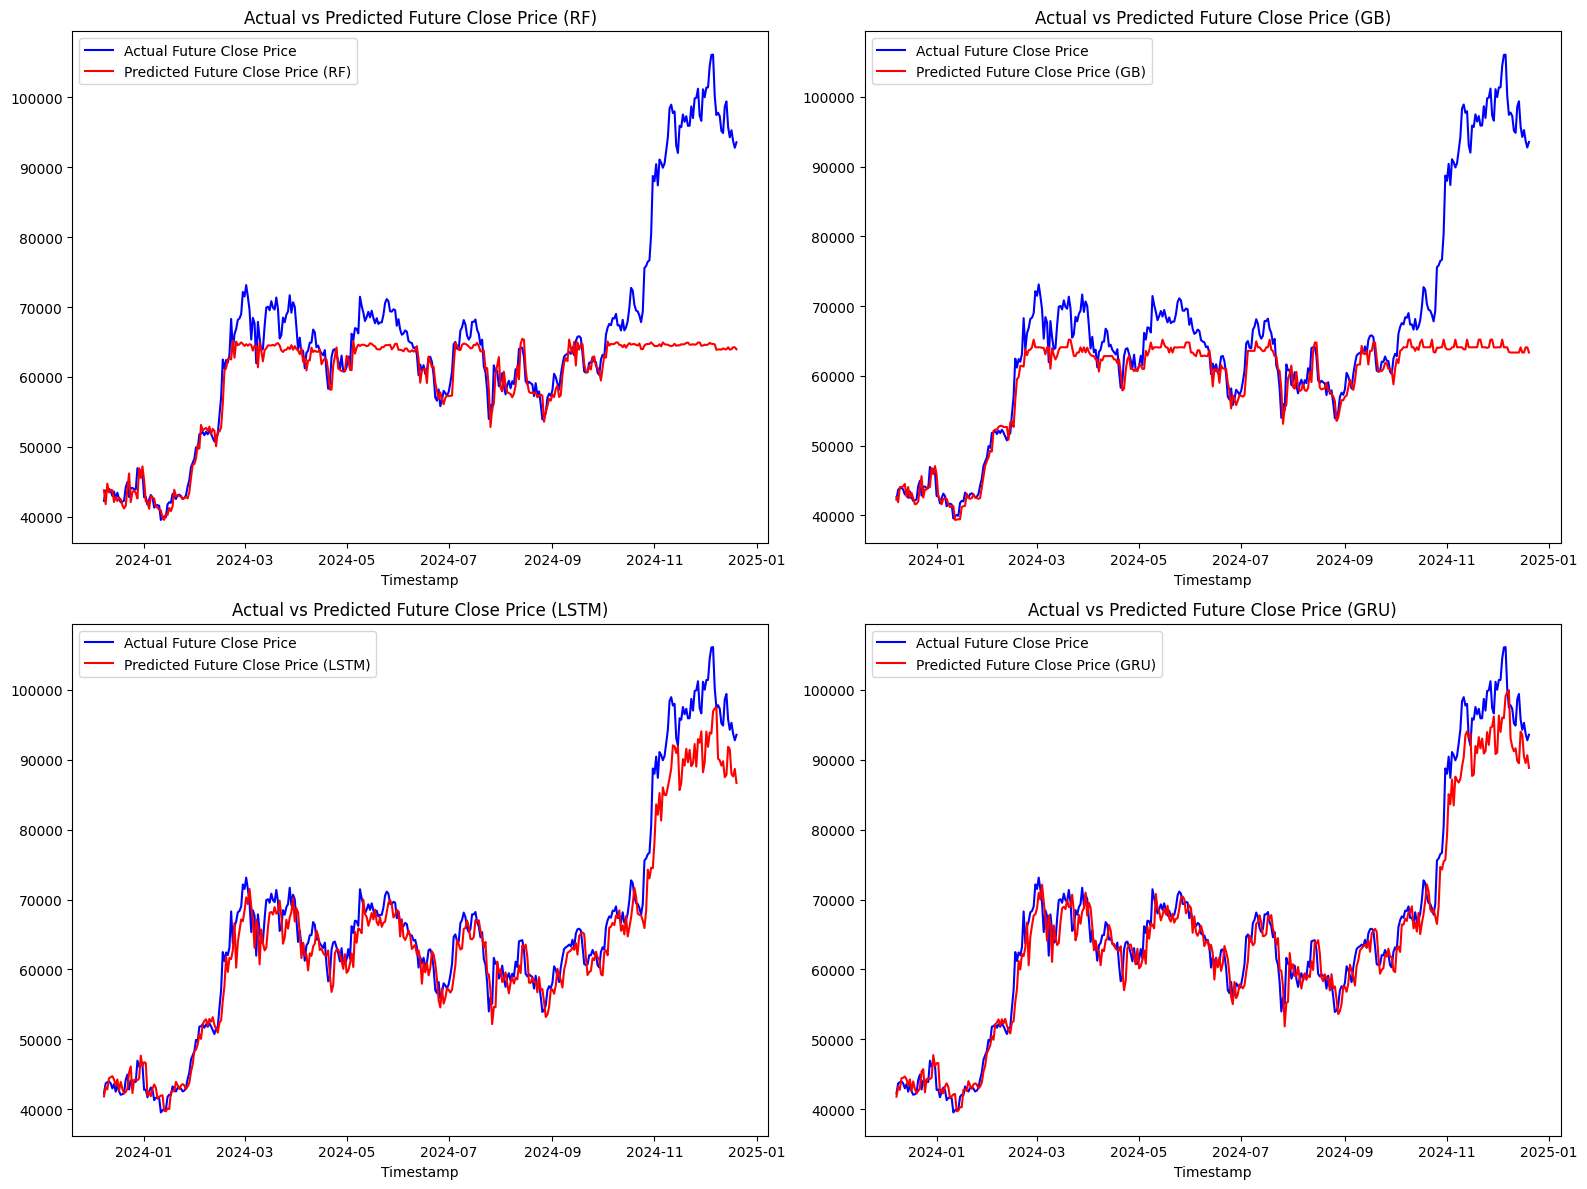

In [23]:
if prediction_type != PredictionType.TREND_DIRECTION:
    def inverse_scale_predictions(predictions, scaler, column_index=0):
        expanded_predictions = np.zeros((len(predictions), scaler.n_features_in_))
        expanded_predictions[:, column_index] = predictions
        return scaler.inverse_transform(expanded_predictions)[:, column_index]

    def plot_predictions(title, model_name, actual_values, predictions, timestamps):
        min_length = min(len(timestamps), len(actual_values), len(predictions))
        timestamps = timestamps[:min_length]
        actual_values = actual_values[:min_length]
        predictions = predictions[:min_length]
        plt.plot(timestamps, actual_values, label=f'Actual {title}', color='blue')
        plt.plot(timestamps, predictions, label=f'Predicted {title} ({model_name})', color='red')
        plt.title(f'Actual vs Predicted {title} ({model_name})')
        plt.xlabel('Timestamp')
        plt.legend()

    y_pred_rf_rescaled = inverse_scale_predictions(rf_predictions, scaler)
    y_pred_gb_rescaled = inverse_scale_predictions(gb_predictions, scaler)
    y_pred_lstm_rescaled = inverse_scale_predictions(lstm_predictions.ravel(), scaler)
    y_pred_gru_rescaled = inverse_scale_predictions(gru_predictions.ravel(), scaler)

    y_test_rescaled = inverse_scale_predictions(y_test, scaler)

    test_data_reset = test_data.reset_index()
    timestamps = test_data_reset['Timestamp'].values  
    actual_values = y_test_rescaled

    models = {
        'RF': y_pred_rf_rescaled,
        'GB': y_pred_gb_rescaled,
        'LSTM': y_pred_lstm_rescaled,
        'GRU': y_pred_gru_rescaled
    }

    if prediction_type == PredictionType.CURRENT_CLOSE_PRICE:
        title = "Current Close Price"
    elif prediction_type == PredictionType.FUTURE_CLOSE_PRICE:
        title = "Future Close Price"
    elif prediction_type == PredictionType.TREND_DIRECTION:
        title = "Trend Direction"
    elif prediction_type == PredictionType.FUTURE_PRICE_CHANGE:
        title = "Price Change"

    plt.figure(figsize=(16, 12))  
    for idx, (model_name, predictions) in enumerate(models.items(), start=1):
        plt.subplot(2, 2, idx)
        plot_predictions(title, model_name, actual_values, predictions, timestamps)
    plt.tight_layout()  
    plt.show()

Modele Random Forest (RF) i Gradient Boosting (GB) oparte na drzewach decyzyjnych, mają tendencję do ograniczania swoich przewidywań do zakresu danych, które były dostępne w trakcie trenowania, a poza nimi nie potrafią ekstrapolować. Na tych danych testowych widać, że nie poradziły sobie z przewidzeniem ceny gdy wzrosły ponad wartości dostępne w danych treningowych.

## Miarowanie Wydajności (RMSE, MSE, MAE, R²)

- RMSE - Im mniejsze, tym lepiej
- MSE  - Im mniejsze, tym lepiej
- MAE  - Im mniejsze, tym lepiej
- R²   - Im większe, tym lepiej

In [24]:
if prediction_type != PredictionType.TREND_DIRECTION:
    metrics = []

    def calculate_metrics(model_name, y_test, predictions):
        rmse = root_mean_squared_error(y_test, predictions)
        mse = mean_squared_error(y_test, predictions)
        mae = mean_absolute_error(y_test, predictions)
        r2 = r2_score(y_test, predictions)
        return {
            'Model': model_name,
            'RMSE': rmse,
            'MSE': mse,
            'MAE': mae,
            'R2': r2
        }

    metrics.append(calculate_metrics('RF', y_test, rf_predictions))
    metrics.append(calculate_metrics('GB', y_test, gb_predictions))
    metrics.append(calculate_metrics('LSTM', y_test_lstm, lstm_predictions))
    metrics.append(calculate_metrics('GRU', y_test_gru, gru_predictions))

    metrics_regression = pd.DataFrame(metrics)
    metrics_regression.set_index('Model', inplace=True)
    metrics_regression = metrics_regression.round(4)
    display(metrics_regression)

,RMSE,MSE,MAE,R2
Model,,,,
RF,0.1201,0.0144,0.0623,0.3428
GB,0.1219,0.0149,0.0644,0.3226
LSTM,0.0367,0.0013,0.0260,0.9386
GRU,0.0310,0.0010,0.0224,0.9562


Na podstawie wyników ewaluacji regresji, modele LSTM oraz GRU osiągnęły najlepsze wyniki. Niemniej jednak, ich obiecująca dokładność powinna być oceniana w kontekście praktycznego zastosowania modelu, zwłaszcza pod kątem tego, czy przewidywana cena wykazuje podobny trend do rzeczywistej ceny, a nie tylko dokładność punktową. Istotne jest, aby modele dobrze odwzorowywały dynamikę rynku, a nie tylko dopasowywały się do historycznych danych.

## Miarowanie Wydajności (Accuracy, Precision, Recall, F1-Score)

Aby lepiej zobrazować dokładność modeli oraz ich potencjalną opłacalność w przewidywaniu cen, można potraktować problem regresji jako klasyfikację. W tym przypadku polega to na przekształceniu prognozowanych cen na wartości dyskretne, które będą reprezentować kierunek trendu, na przykład jako wzrost jako 1 i spadek jako 0. Taki sposób analizy pozwala na ocenę, czy modele są w stanie przewidywać zmiany rynkowe w sposób, który może być wykorzystany do podejmowania decyzji inwestycyjnych.

In [25]:
def evaluate_classification_metrics(actual_values, predicted_values):
    min_length = min(len(actual_values), len(predicted_values))
    actual_values = actual_values[:min_length]
    actual_changes = np.sign(np.diff(actual_values))
    predicted_changes = np.sign(np.diff(predicted_values))
    
    actual_changes_binary = (actual_changes > 0).astype(int)
    predicted_changes_binary = (predicted_changes > 0).astype(int)
    
    accuracy = accuracy_score(actual_changes_binary, predicted_changes_binary)
    precision = precision_score(actual_changes_binary, predicted_changes_binary)
    recall = recall_score(actual_changes_binary, predicted_changes_binary)
    f1 = f1_score(actual_changes_binary, predicted_changes_binary)
    
    return accuracy, precision, recall, f1

metrics_classification = []

models_predictions = {
    'RF': y_pred_rf_rescaled,
    'GB': y_pred_gb_rescaled,
    'LSTM': y_pred_lstm_rescaled,
    'GRU': y_pred_gru_rescaled
}

for model, predictions in models_predictions.items():

    accuracy, precision, recall, f1 = evaluate_classification_metrics(actual_values, predictions)
    
    model_classification_metrics = {
        'Model': model,
        'Accuracy': round(accuracy, 2),
        'Precision': round(precision, 2),
        'Recall': round(recall, 2),
        'F1-score': round(f1, 2)
    }
    
    metrics_classification.append(model_classification_metrics)

metrics_classification_df = pd.DataFrame(metrics_classification)
metrics_classification_df.set_index('Model', inplace=True)

display(metrics_classification_df)

,Accuracy,Precision,Recall,F1-score
Model,,,,
RF,0.49,0.53,0.48,0.50
GB,0.52,0.57,0.41,0.47
LSTM,0.51,0.54,0.54,0.54
GRU,0.51,0.54,0.55,0.55


Na podstawie wyników ewaluacji klasyfikacji najlepszy okazał się model Random Forest. Niemniej jednak, w praktyce, jeżeli celem byłoby podejmowanie decyzji o inwestowaniu w BTC na podstawie tego modelu, efekt mógłby być równie przypadkowy, jak codzienne rzucanie monetą. Model w tym przypadku nie zapewnia istotnej przewagi w podejmowaniu decyzji, a jego skuteczność w realnych warunkach rynkowych może być ograniczona.